In [1]:
cd ..

/home/janek/mag/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import random
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data, reduce_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [5]:
data_tr, data_vl, data_tr_p2, data_vl_p2, idx_te, X_te, y_te = prepare_data(data_tr, data_vl, data_te, seed, 4)

In [6]:
data_tr_p2 = reduce_dataset(data_tr_p2, len(test_onto), 1325, [idx_te, X_te, y_te])

In [7]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_tr_p2[2]))
print(np.mean(data_vl_p2[2]))
print(np.mean(y_te))

0.21857221508533675
0.21258330066640532

0.2101132075471698
0.207749766573296
0.20907114010562286


In [8]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_tr_p2[2]))
print(len(data_vl_p2[2]))
print(len(y_te))

54490
25510

26500
6426
6438


In [9]:
emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

In [8]:
#FIRST PHASE
T.manual_seed(seed)
reasoner_original = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_original = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_original)} parameters')
print(f'created {len(encoders_original)} encoders with {paramcount(encoders_original[0])} parameters each')

T.manual_seed(seed)
reasoner_mod = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_mod = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_mod)} parameters')
print(f'created {len(encoders_mod)} encoders with {paramcount(encoders_mod[0])} parameters each')

train_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    random.seed(seed)
    if reasoner_name == 'original reasoner':
        train(data_tr, data_vl, reasoner, encoders_original, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger)
    else:
        train_mod(data_tr, data_vl, reasoner, encoders_mod, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger, identities_weight=0.028, identitity_weight_decay=0.96)


created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
original reasoner
train epoch 00/15 | batch 1704/1703 | loss 0.7203 | val loss 0.7206 | acc 0.2125 | f1 0.3505 | prec 0.2125 | recall 0.9994 | roc auc 0.5276 | pr auc 0.2303 | elapsed 17.45s
train epoch 01/15 | batch 1704/1703 | loss 0.5899 | val loss 0.5075 | acc 0.7978 | f1 0.1014 | prec 0.9151 | recall 0.0537 | roc auc 0.5890 | pr auc 0.3256 | elapsed 33.52s
train epoch 02/15 | batch 1704/1703 | loss 0.4514 | val loss 0.4774 | acc 0.8013 | f1 0.2551 | prec 0.6276 | recall 0.1601 | roc auc 0.7018 | pr auc 0.4395 | elapsed 34.89s
train epoch 03/15 | batch 1704/1703 | loss 0.3383 | val loss 0.4917 | acc 0.8128 | f1 0.3947 | prec 0.6314 | recall 0.2871 | roc auc 0.7389 | pr auc 0.5165 | elapsed 32.72s
train epoch 04/15 | batch 1704/1703 | loss 0.2566 | val loss 0.5049 | acc 0.8194 | f1 0.4667 | prec 0.6269 | recall 0.3717

In [11]:
## --- SECOND PHASE
trained_test_encoders = {}
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'original reasoner':
        train(data_tr_p2, data_vl_p2, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)
    else:
        train_mod(data_tr_p2, data_vl_p2, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)


original reasoner
train epoch 00/10 | batch 830/829 | loss 1.2252 | val loss 1.2663 | acc 0.6334 | f1 0.3632 | prec 0.2841 | recall 0.5034 | roc auc 0.6302 | pr auc 0.3802 | elapsed 6.71s
train epoch 01/10 | batch 830/829 | loss 1.0627 | val loss 1.1186 | acc 0.6659 | f1 0.3800 | prec 0.3092 | recall 0.4929 | roc auc 0.6521 | pr auc 0.4031 | elapsed 14.12s
train epoch 02/10 | batch 830/829 | loss 0.7538 | val loss 1.0076 | acc 0.6920 | f1 0.3950 | prec 0.3337 | recall 0.4839 | roc auc 0.6721 | pr auc 0.4257 | elapsed 11.55s
train epoch 03/10 | batch 830/829 | loss 0.5343 | val loss 0.9299 | acc 0.7168 | f1 0.4196 | prec 0.3654 | recall 0.4929 | roc auc 0.6896 | pr auc 0.4470 | elapsed 12.74s
train epoch 04/10 | batch 830/829 | loss 0.3898 | val loss 0.8768 | acc 0.7316 | f1 0.4324 | prec 0.3856 | recall 0.4921 | roc auc 0.7043 | pr auc 0.4665 | elapsed 13.80s
train epoch 05/10 | batch 830/829 | loss 0.2966 | val loss 0.8415 | acc 0.7470 | f1 0.4496 | prec 0.4101 | recall 0.4974 | roc a

In [12]:
with T.no_grad():
    _, _, Y_te_orig = eval_batch(reasoner_original, trained_test_encoders['original reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_mod = eval_batch(reasoner_mod, trained_test_encoders['modified reasoner'], X_te, y_te, idx_te)

local/out/exp/20240808T161858


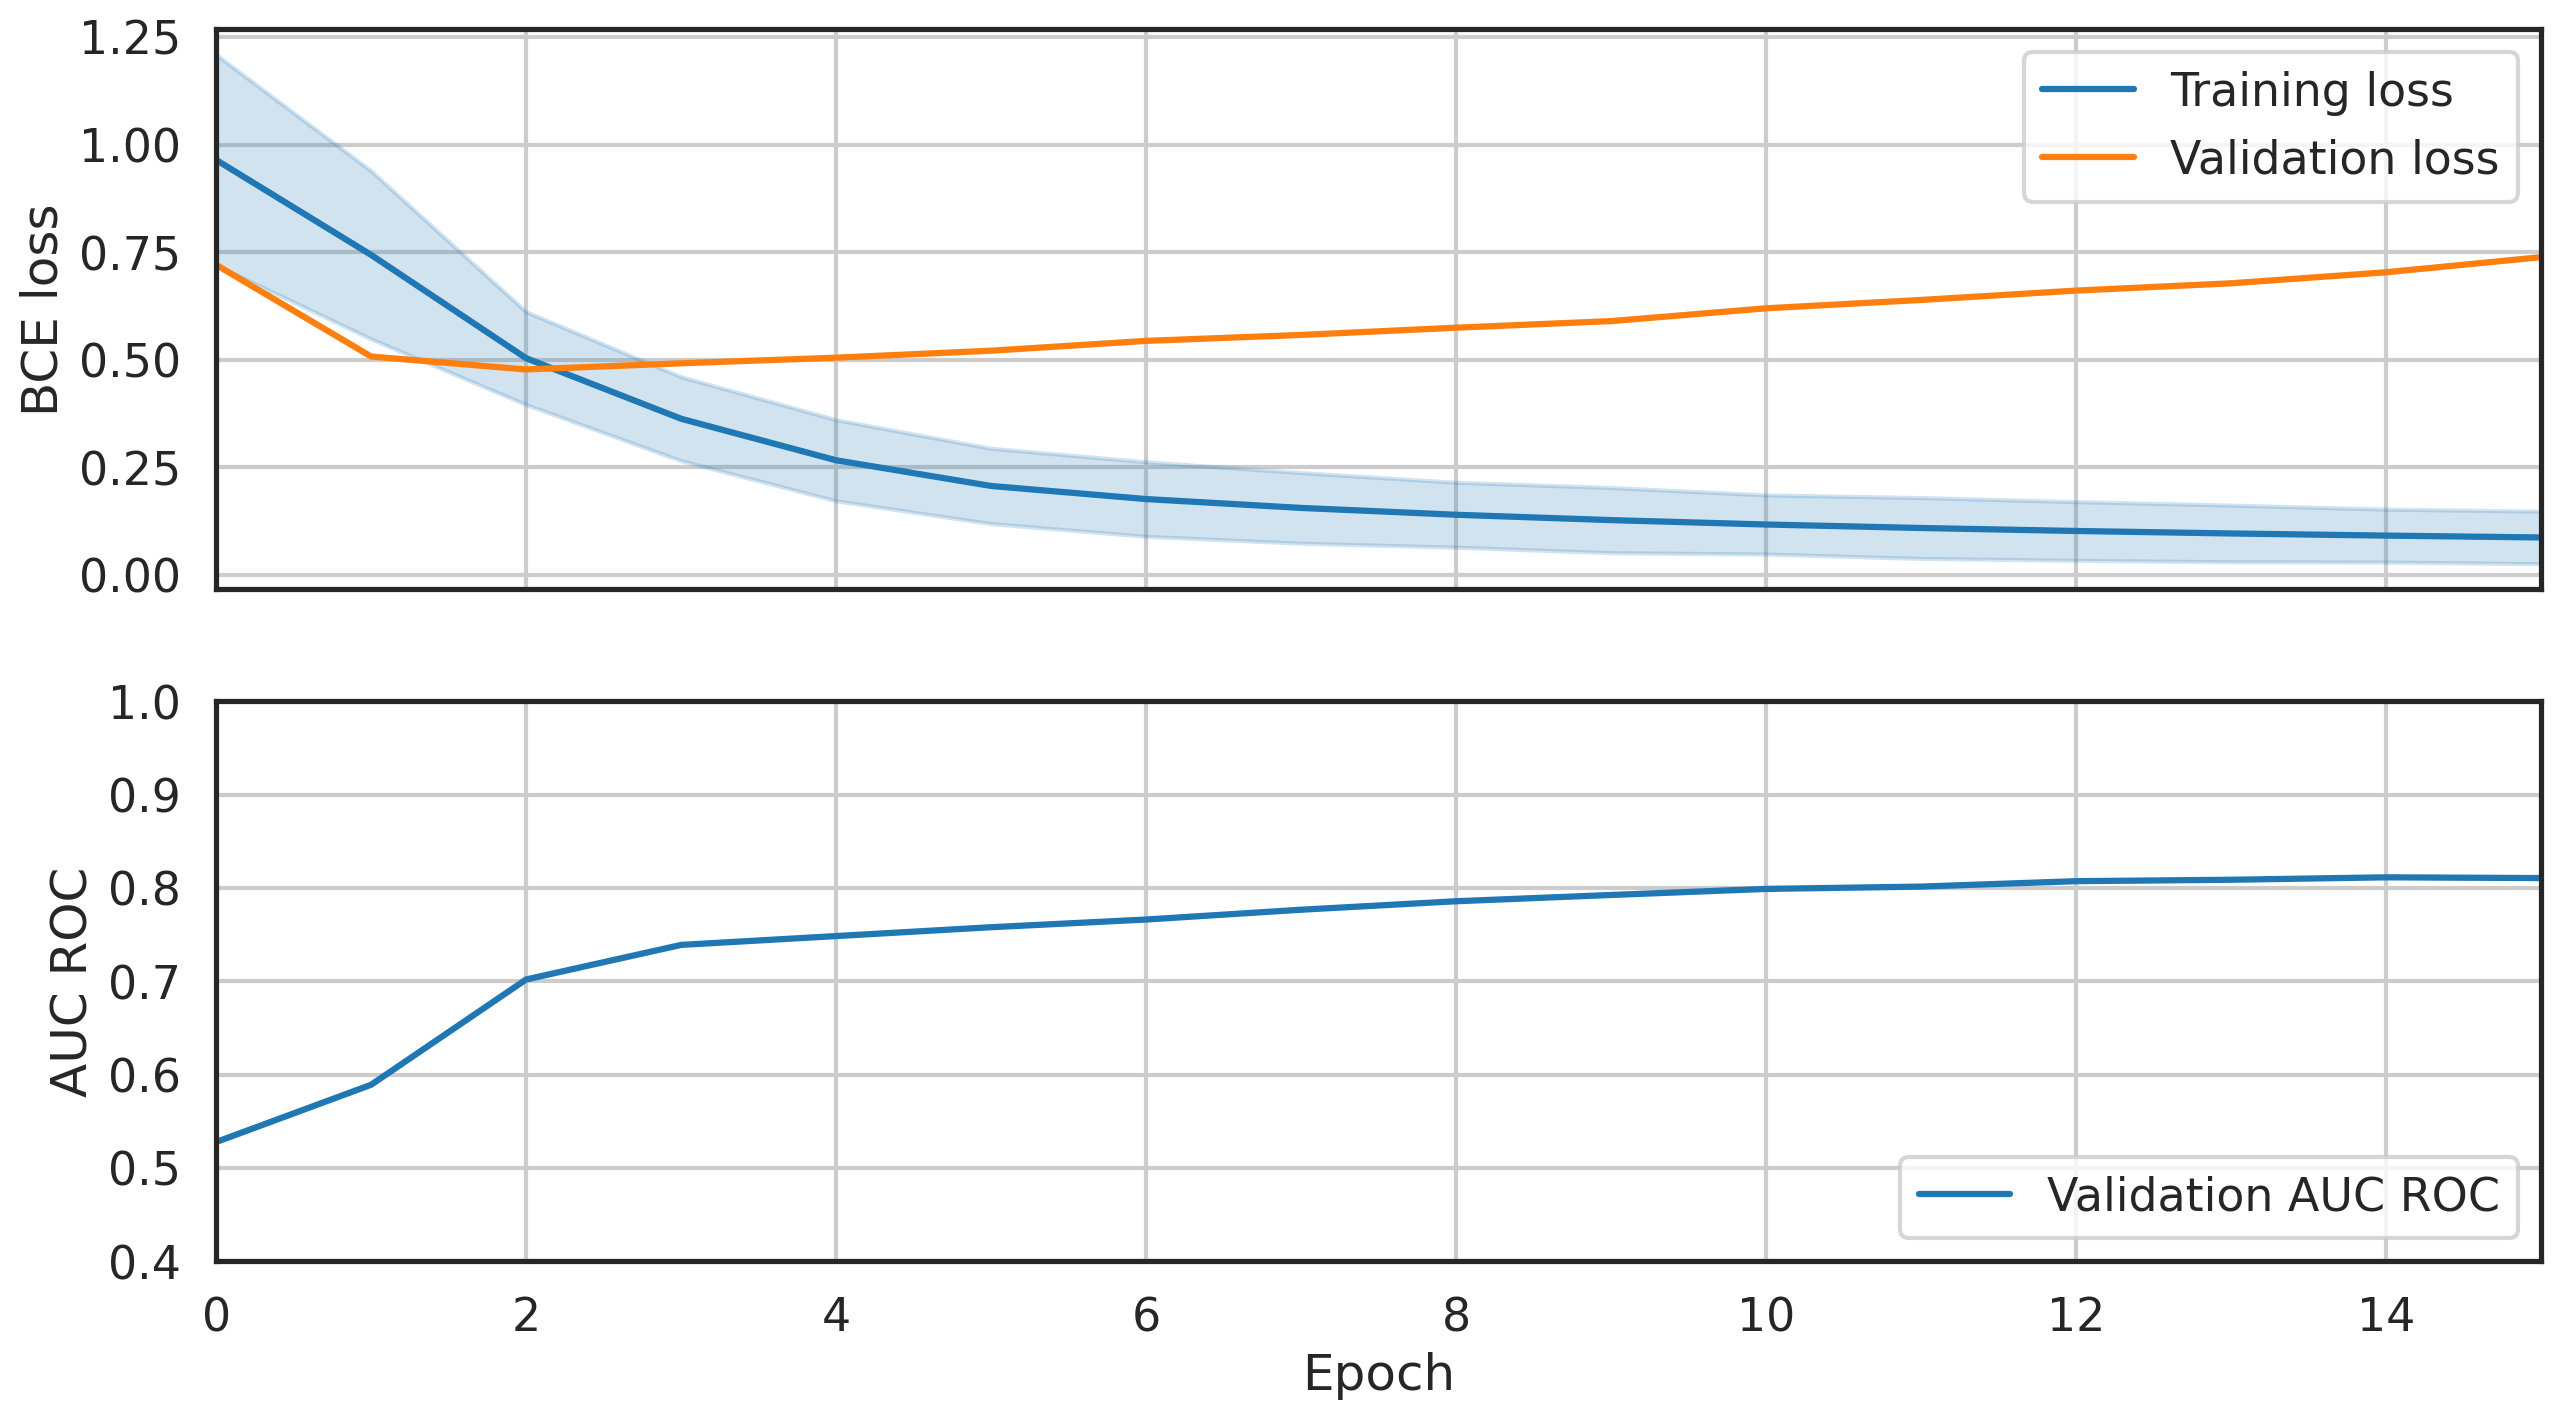

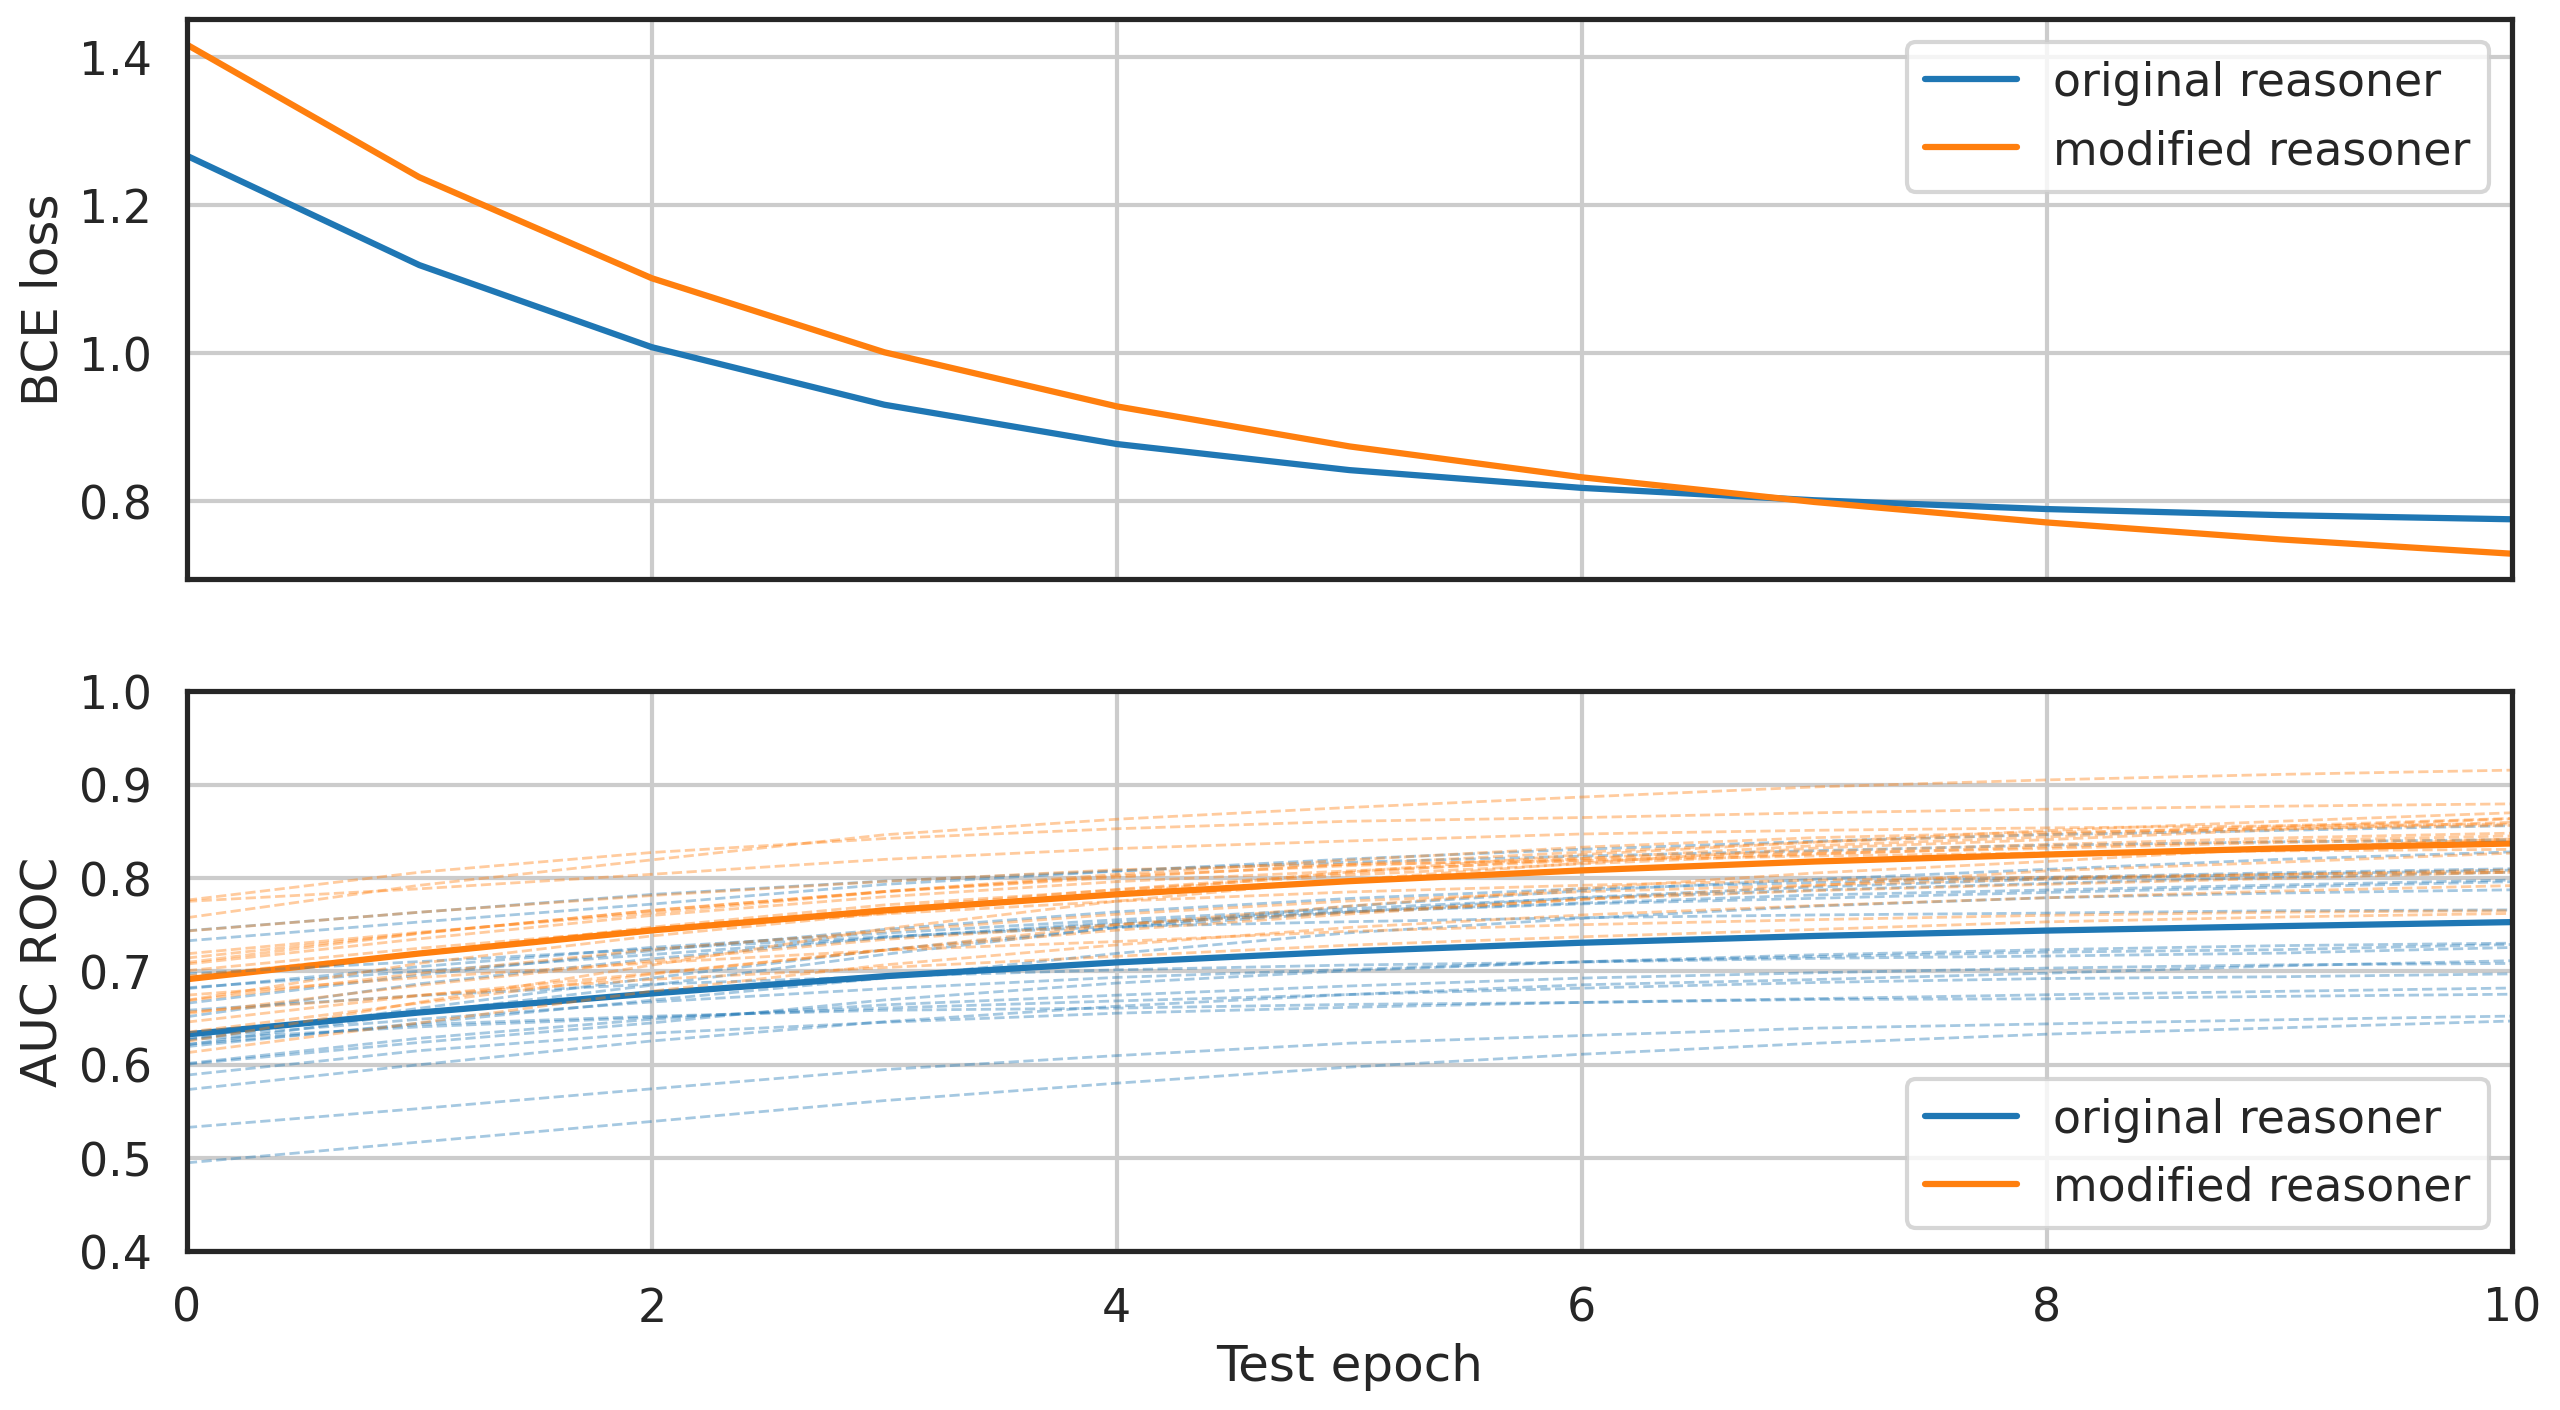

original
             mean       std     micro
acc      0.801027  0.050232  0.800559
prec     0.545177  0.131186  0.521031
recall   0.576891  0.099328  0.570579
f1       0.545504  0.062449  0.544681
auc_roc  0.784948  0.056724  0.776538
auc_pr   0.609994  0.085083  0.582943
modified
             mean       std     micro
acc      0.760079  0.061370  0.760485
prec     0.468122  0.112152  0.456752
recall   0.772996  0.075693  0.768945
f1       0.574018  0.084530  0.573090
auc_roc  0.853937  0.044712  0.853092
auc_pr   0.719897  0.095566  0.720832


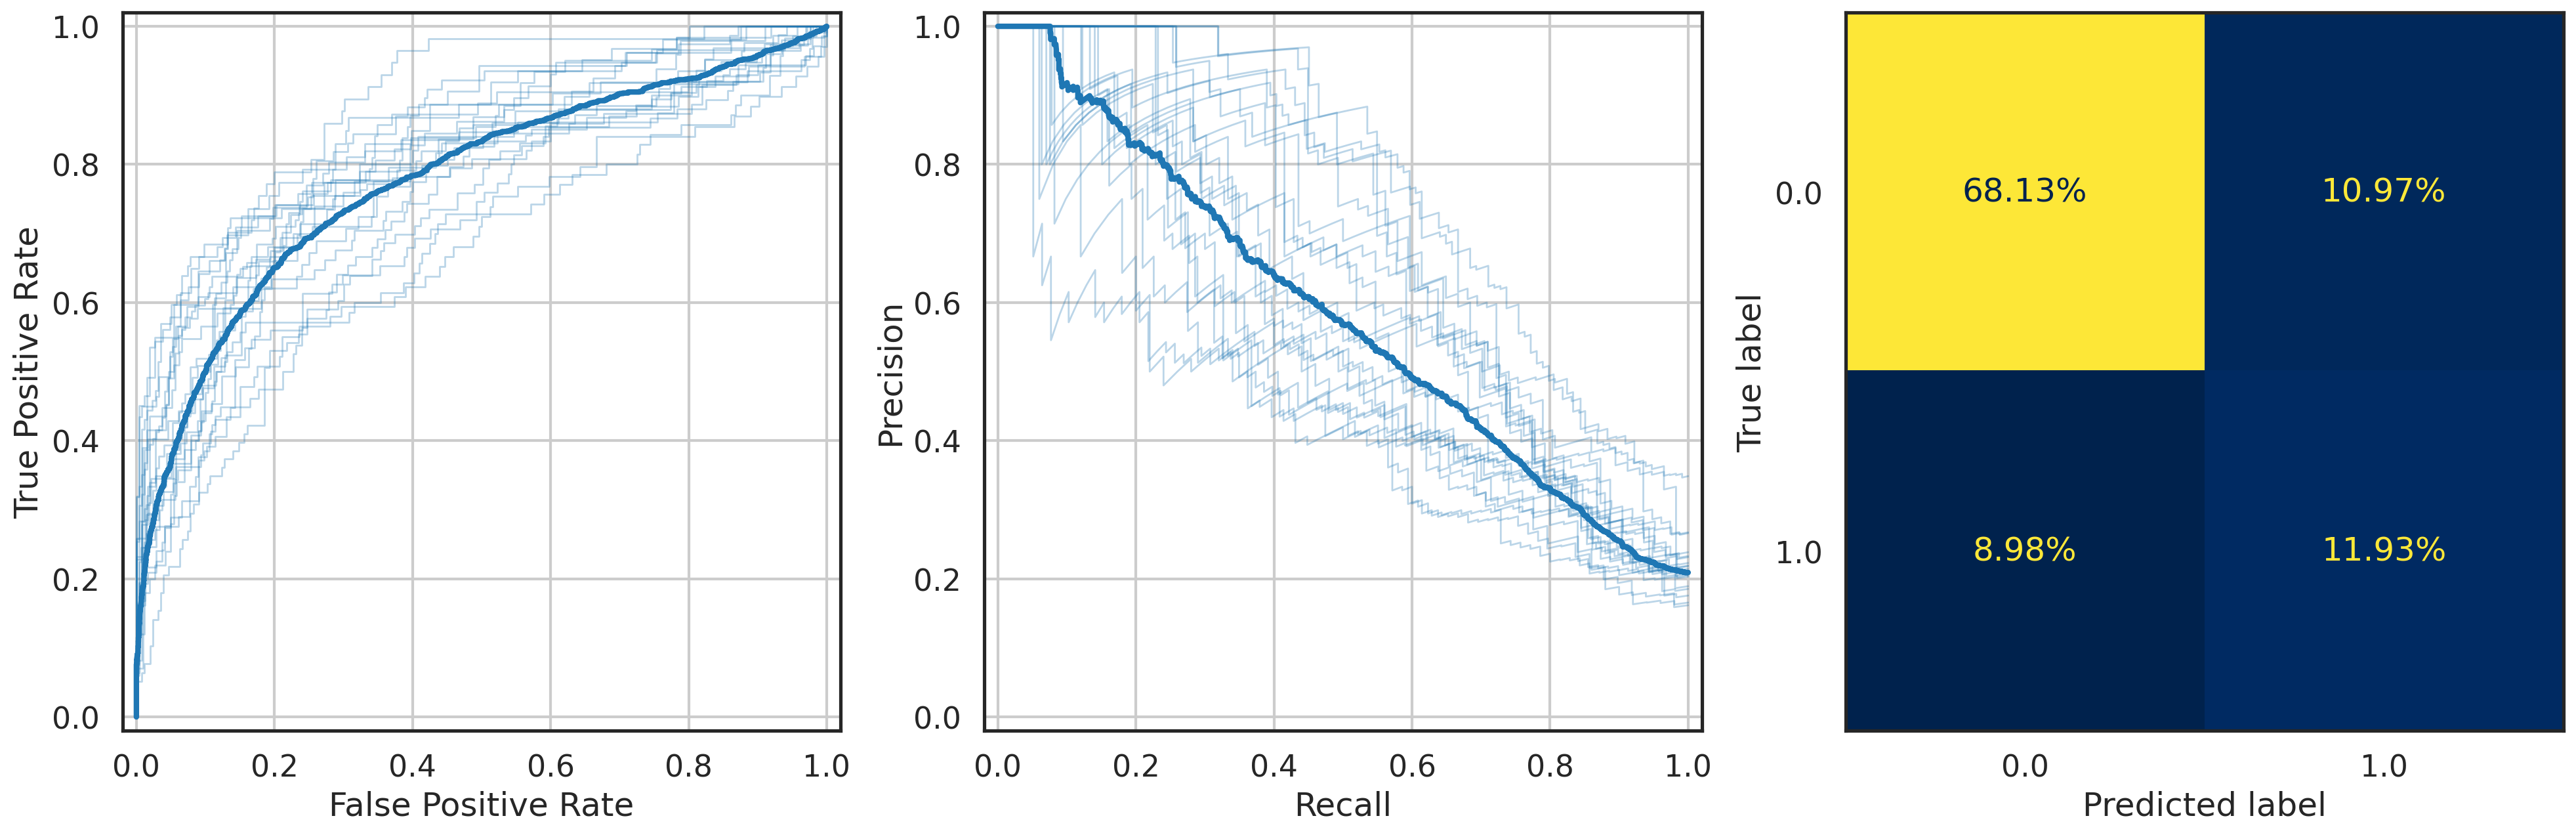

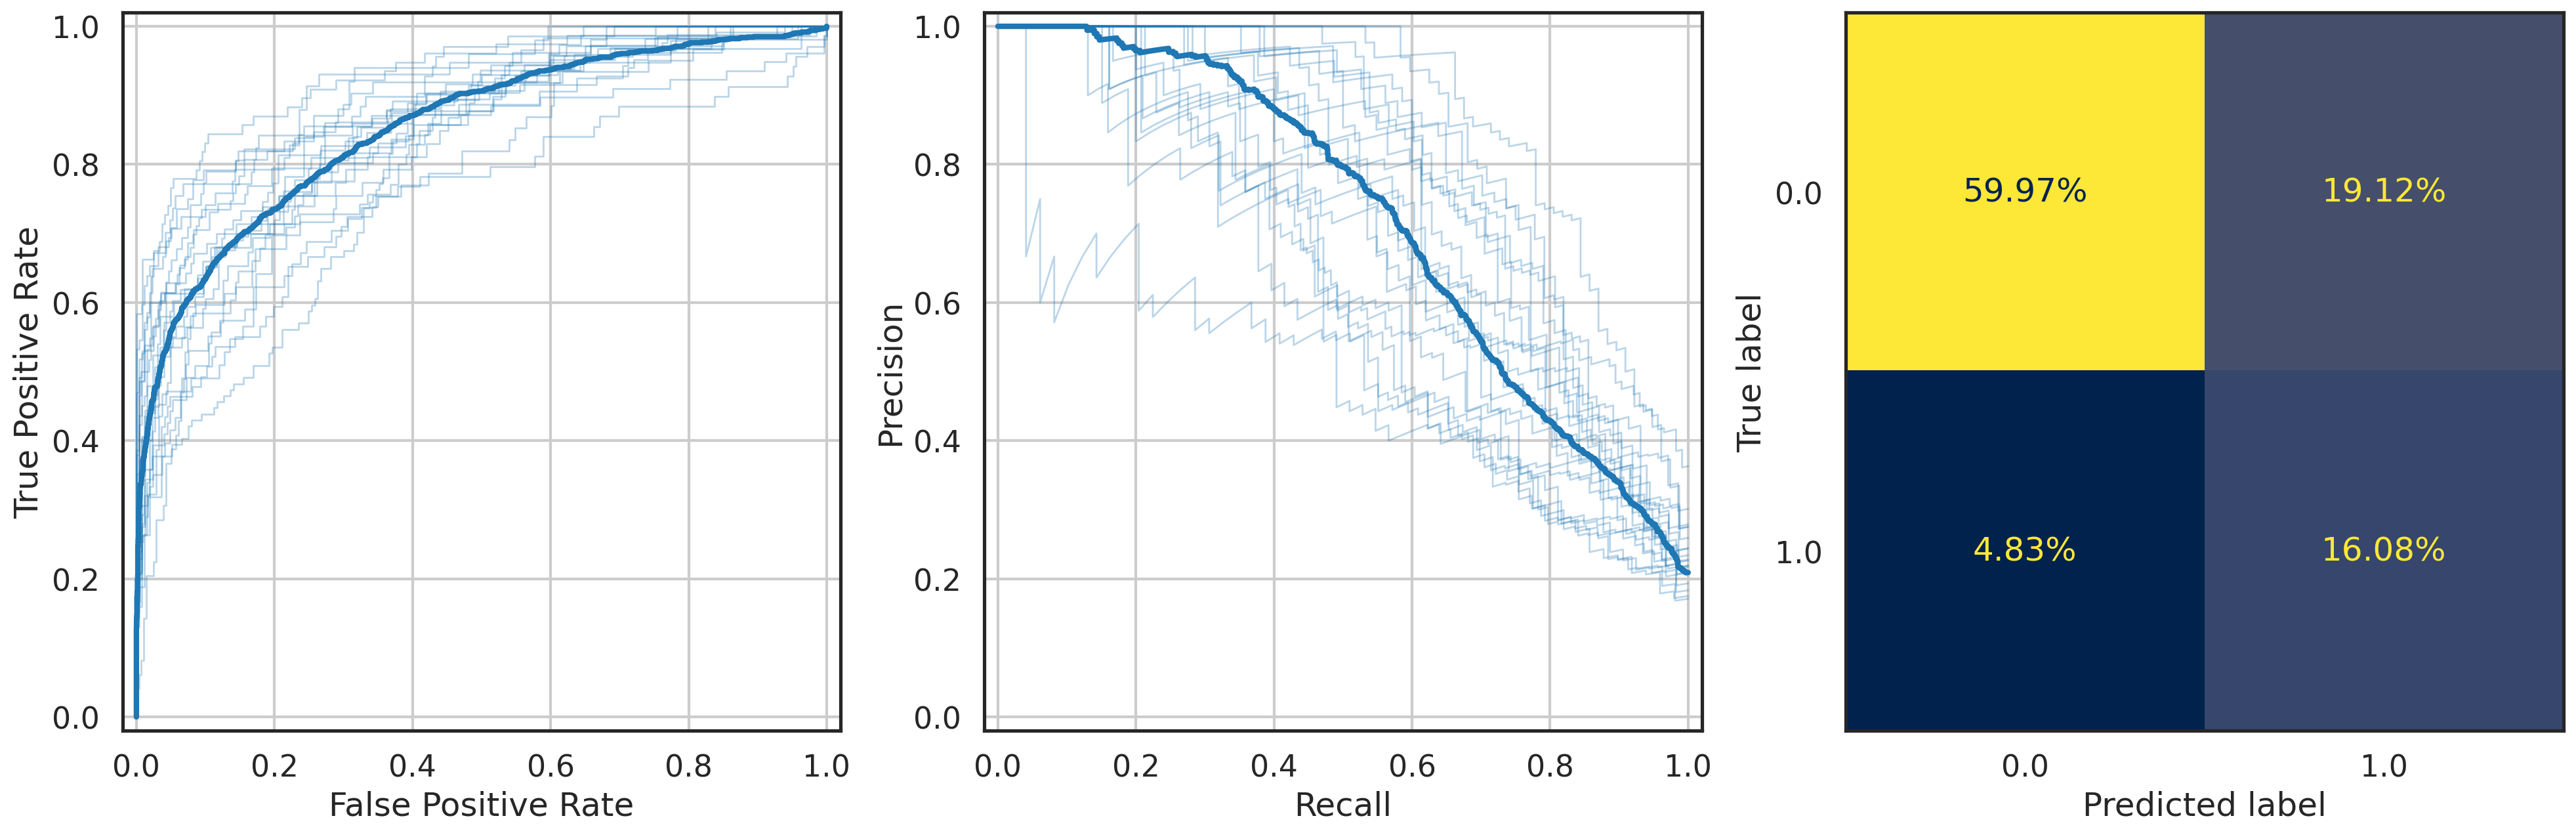

In [14]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(reasoner_original.state_dict(), base+'/reasonerO.pt')
T.save(reasoner_mod.state_dict(), base+'/reasonerM.pt')

df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_orig=Y_te_orig, Y_te_mod=Y_te_mod))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print('original')
print(report(test_onto, y_te, np.array(Y_te_orig), idx_te, save=base+'/%-trained'))
print('modified')
print(report(test_onto, y_te, np.array(Y_te_mod), idx_te, save=base+'/%-random'))

In [15]:
from src.id import print_identity_results
print(print_identity_results(reasoner_original,trained_test_encoders['original reasoner'], seed))

Double Negation:
  Mean Loss: 0.236425
  Std Dev Loss: 0.034047
  Mean Diff: 0.559462
  Std Dev Diff: 0.103977

Duality of Top and Bottom:
  Mean Loss: 0.335481
  Std Dev Loss: 0.000000
  Mean Diff: 0.692846
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.129816
  Std Dev Loss: 0.038049
  Mean Diff: 0.314691
  Std Dev Diff: 0.094528

Associativity:
  Mean Loss: 0.050097
  Std Dev Loss: 0.032289
  Mean Diff: 0.098719
  Std Dev Diff: 0.045434

Commutativity:
  Mean Loss: 0.037934
  Std Dev Loss: 0.012962
  Mean Diff: 0.088200
  Std Dev Diff: 0.031726

Contradiction:
  Mean Loss: 0.418508
  Std Dev Loss: 0.017429
  Mean Diff: 0.875815
  Std Dev Diff: 0.051773

Identity with Top:
  Mean Loss: 0.171751
  Std Dev Loss: 0.038160
  Mean Diff: 0.467062
  Std Dev Diff: 0.124899

Absorption by Bottom:
  Mean Loss: 0.609418
  Std Dev Loss: 0.026895
  Mean Diff: 1.263673
  Std Dev Diff: 0.069489

Top Concept Subsumption:
  Mean Loss: 0.000880
  Std Dev Loss: 0.000987
  Mean Diff: N/A
  Std De

In [16]:
print(print_identity_results(reasoner_mod,trained_test_encoders['modified reasoner'], seed))

Double Negation:
  Mean Loss: 0.000009
  Std Dev Loss: 0.000003
  Mean Diff: 0.000021
  Std Dev Diff: 0.000009

Duality of Top and Bottom:
  Mean Loss: 0.000164
  Std Dev Loss: 0.000000
  Mean Diff: 0.000463
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.124612
  Std Dev Loss: 0.025522
  Mean Diff: 0.301746
  Std Dev Diff: 0.073296

Associativity:
  Mean Loss: 0.018213
  Std Dev Loss: 0.006184
  Mean Diff: 0.041812
  Std Dev Diff: 0.014178

Commutativity:
  Mean Loss: 0.021816
  Std Dev Loss: 0.008123
  Mean Diff: 0.053832
  Std Dev Diff: 0.021034

Contradiction:
  Mean Loss: 0.122163
  Std Dev Loss: 0.028797
  Mean Diff: 0.200844
  Std Dev Diff: 0.039421

Identity with Top:
  Mean Loss: 0.064490
  Std Dev Loss: 0.017311
  Mean Diff: 0.157495
  Std Dev Diff: 0.048251

Absorption by Bottom:
  Mean Loss: 0.025653
  Std Dev Loss: 0.009211
  Mean Diff: 0.053672
  Std Dev Diff: 0.015104

Top Concept Subsumption:
  Mean Loss: 0.000357
  Std Dev Loss: 0.000341
  Mean Diff: N/A
  Std De